# Final Project: iPhone or Not
*Boris Evstratov*

### 0. Importing packages

In [0]:
from keras import models, layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from sklearn.metrics import average_precision_score, precision_recall_curve
import tensorflow as tf
from tensorflow.contrib import lite
import numpy as np
import matplotlib.pyplot as plt

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

### 1. Creating a Residual Network
*source*: [Hitchhiker’s Guide to Residual Networks (ResNet) in Keras](https://towardsdatascience.com/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff)

#### 1.1 Define the identity block

In [0]:
def identity_block(X, f, filters, stage, block):
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

#### 1.2 Define the convolution block

In [0]:
def convolutional_block(X, f, filters, stage, block, s=2):

    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

#### 1.3 Biuld the model
Combining both blocks into a 50-layer residual network

In [0]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

### 2. Data management

#### 2.1 Data import

In [0]:
# Unzipping uploaded dataset
from zipfile import ZipFile
zip = ZipFile('data.zip')
zip.extractall()

In [0]:
# Specifying data paths and necessary parameters
dataset_path = 'data'
train_path = dataset_path + '/train'
test_path = dataset_path + '/test'
image_res = 224
batch_size = 32
epochs_nb = 10

#### 2.2 Data preprocessing

In [0]:
# Setting ImageDataGenerators
train_datagen = ImageDataGenerator(brightness_range = [0.3, 1.5], 
                                   channel_shift_range = 30,
                                   rescale = 1./255,
                                   rotation_range = 90,
                                   shear_range = 0.3,
                                   zoom_range = 0.2,
                                   vertical_flip = True,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [8]:
# Generating Flows from directories
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (image_res, image_res),
                                                 batch_size = batch_size,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (image_res, image_res),
                                            batch_size = batch_size,
                                            class_mode = 'binary',
                                            shuffle=False)

Found 24457 images belonging to 2 classes.
Found 6884 images belonging to 2 classes.


### 3. Model training

In [0]:
model = ResNet50(input_shape = (image_res, image_res, 3), classes = 2)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
# Define checkpoints for CNN autosaving
filepath= "cnn-cv-iphone-resnet-50.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

In [13]:
# Training the model
model.fit_generator(train_set,
                         steps_per_epoch = train_set.samples / batch_size,
                         epochs = epochs_nb,
                         validation_data = test_set,
                         validation_steps = test_set.samples / batch_size,
                         verbose = 1,
                         callbacks=[checkpoint])

Epoch 1/25
765/764 [==============================] - 428s 559ms/step - loss: 11.3266 - acc: 0.2895 - val_loss: 11.7368 - val_acc: 0.2638

Epoch 00001: acc improved from -inf to 0.28949, saving model to cnn-cv-iphone-resnet-50.hdf5
Epoch 2/25
765/764 [==============================] - 425s 555ms/step - loss: 11.2094 - acc: 0.2969 - val_loss: 11.7368 - val_acc: 0.2638

Epoch 00002: acc improved from 0.28949 to 0.29685, saving model to cnn-cv-iphone-resnet-50.hdf5
Epoch 3/25
765/764 [==============================] - 423s 553ms/step - loss: 11.3027 - acc: 0.2910 - val_loss: 11.7368 - val_acc: 0.2638

Epoch 00003: acc did not improve from 0.29685
Epoch 4/25
765/764 [==============================] - 422s 552ms/step - loss: 11.2417 - acc: 0.2949 - val_loss: 11.7368 - val_acc: 0.2638

Epoch 00004: acc did not improve from 0.29685
Epoch 5/25
765/764 [==============================] - 419s 547ms/step - loss: 11.3286 - acc: 0.2894 - val_loss: 11.7368 - val_acc: 0.2638

Epoch 00005: acc did not

In [16]:
! ls

cnn-cv-iphone-resnet-50.hdf5  data  data.zip  __MACOSX	sample_data


### 4. Model check

#### 4.1 Predictions

In [18]:
test_set.reset()
model_pred = model.predict_generator(test_set, 
                                    steps= test_set.samples / batch_size, 
                                    verbose=1)

216/215 [==============================] - 28s 131ms/step


#### 4.2 Precision, Recall, AUC

In [22]:
avg_precision = average_precision_score(test_set.classes, [i[0] for i in model_pred])
print('Average precision-recall score',avg_precision)

Average precision-recall score: 0.26380011621150495


Text(0.5, 1.0, '2-class Precision-Recall curve')

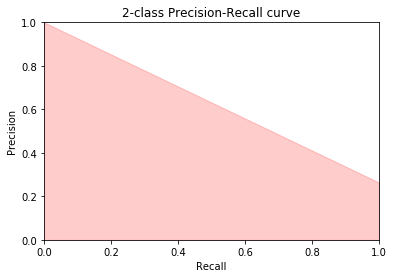

In [28]:
precision, recall, _ = precision_recall_curve(test_set.classes, [i[0] for i in model_pred])
plt.fill_between(recall, precision, alpha=0.2, color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')

### 5. Conclusion
We can see that from-scratch implementation of ResNet-50 showed poor performance and gained low values of important metrics.
Thus, I would like to take one more approach with pre-trained ResNet-50 CNN from Keras library.

### 6. Keras ResNet CNN

In [0]:
# Import ResNet50 CNN 
from keras.applications import ResNet50 as RN50

In [0]:
# Specify parameters for CNN
img_size = 224
batch_size = 32

In [45]:
# Generating Flows from directories for the new ResNet
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (img_size, img_size),
                                                 batch_size = batch_size,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (img_size, img_size),
                                            batch_size = batch_size,
                                            class_mode = 'binary',
                                            shuffle=False)

Found 24457 images belonging to 2 classes.
Found 6884 images belonging to 2 classes.


In [48]:
# Use ResNet50 with pretrained weights from ImageNet dataset
model_RN50 = RN50(weights='imagenet', include_top = False, input_shape = (img_size,img_size,3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
# Tweaking up the preloaded model a little bit
model_new = models.Sequential()
model_new.add(model_RN50)
model_new.add(layers.GlobalAveragePooling2D())

model_new.add(layers.Dense(256,activation='relu'))
model_new.add(layers.Dense(256,activation='relu'))
model_new.add(layers.Dense(1,activation='sigmoid'))

for layer in model_new.layers[:1]:
    layer.trainable = False

model_new.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [0]:
# Define checkpoints for CNN autosaving
filepath= "cnn-cv-iphone-resnet-50-pretrained.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

In [52]:
# Training the model
model_new.fit_generator(train_set,
                         steps_per_epoch = train_set.samples / batch_size,
                         epochs = epochs_nb,
                         validation_data = test_set,
                         validation_steps = test_set.samples / batch_size,
                         verbose = 1,
                         callbacks=[checkpoint])

Epoch 1/20
765/764 [==============================] - 365s 477ms/step - loss: 0.2179 - acc: 0.9143 - val_loss: 0.9495 - val_acc: 0.6737

Epoch 00001: acc improved from -inf to 0.91434, saving model to cnn-cv-iphone-resnet-50-pretrained.hdf5
Epoch 2/20
765/764 [==============================] - 352s 460ms/step - loss: 0.1549 - acc: 0.9411 - val_loss: 0.9598 - val_acc: 0.6549

Epoch 00002: acc improved from 0.91434 to 0.94108, saving model to cnn-cv-iphone-resnet-50-pretrained.hdf5
Epoch 3/20
765/764 [==============================] - 351s 459ms/step - loss: 0.1371 - acc: 0.9492 - val_loss: 1.0934 - val_acc: 0.6053

Epoch 00003: acc improved from 0.94108 to 0.94922, saving model to cnn-cv-iphone-resnet-50-pretrained.hdf5
Epoch 4/20
765/764 [==============================] - 352s 461ms/step - loss: 0.1328 - acc: 0.9518 - val_loss: 0.9370 - val_acc: 0.6880

Epoch 00004: acc improved from 0.94922 to 0.95175, saving model to cnn-cv-iphone-resnet-50-pretrained.hdf5
Epoch 5/20
765/764 [=======

In [58]:
# Predict
test_set.reset()

model_new_pred = model_new.predict_generator(test_set, 
                                    steps= test_set.samples / batch_size, 
                                    verbose=1)

216/215 [==============================] - 32s 148ms/step


In [64]:
# Check the Model's metrics
avg_precision = average_precision_score(test_set.classes, [i[0] for i in model_new_pred])
print('Average precision-recall score',avg_precision)

Average precision-recall score 0.45536740225106964


Text(0.5, 1.0, '2-class Precision-Recall curve')

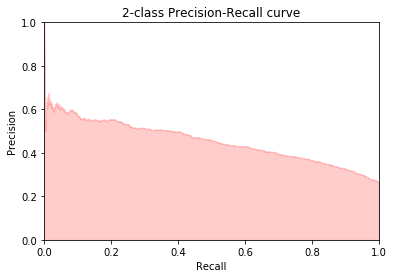

In [65]:
precision, recall, _ = precision_recall_curve(test_set.classes, [i[0] for i in model_new_pred])
plt.fill_between(recall, precision, alpha=0.2, color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')

### 7. Conclusion №2
We can see that pretrained ResNet-50 showed better performance and gained higher values of important metrics, however the model itself is still not that great.

### 8. Compressing and publishing
In order to meet stupid GitHub restriction of max file size 100Mb, I would like to use TFLite to compress the model.

In [70]:
# Converting Keras model to TensorFlow Lite one
converter = lite.TFLiteConverter.from_keras_model_file('cnn-cv-iphone-resnet-50-pretrained.hdf5')
tflite_model = converter.convert()
open("cnn-cv-iphone-resnet-50-pretrained.tflite", "wb").write(tflite_model)

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 324 variables.
INFO:tensorflow:Converted 324 variables to const ops.


96312484

In [0]:
# Generate the requirements file with all of the dependencies
pip freeze > requirements.txt